# Домашнее задание

В этом домашнем задании предлагаем вам попрактиковаться в прогнозировании стоимости биткоина при помощи линейной регрессии.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp'
                  )

data.head()

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204


Будем прогнозировать стоимость биткоина на момент открытия торгов (`open`).

<Axes: xlabel='timestamp'>

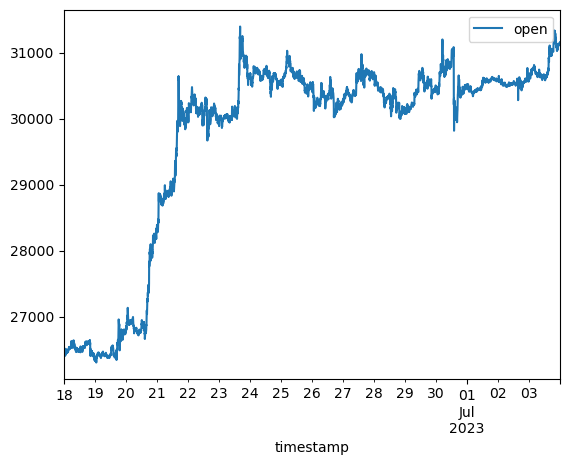

In [38]:
data = data[['open']]

data.plot()

Проделайте следующие шаги:

* Разбейте данные на тренировочную и тестовую часть. В тест отправьте 15% данных

* Извлеките лаговые признаки

* Извлеките агрегированные признаки (средняя стоимость за день, час)

Рекомендуется использовать функцию preprocess_data с вебинара (однако, надо будет незначительно ее поменять, исходя из данных задачи).

Задайте гиперпараметры по умолчанию (в функции preprocess_data, если будете использовать ее):
* `lag_start`=5
* `lag_end`=20
* `test_size`=0.15

In [46]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# первый вариант без доп фичей кроме лагов
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    # your code here

    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['open'].shift(i)
    data = data.dropna()

    data = data.sort_index() # проверка на дурака
    X = data.drop("open", axis=1)
    y = data["open"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test

Обучите линейную регрессию с гиперпараметрами по умолчанию на тренировочных данных и вычислите ошибку MAE на тестовых данных.

Чему она получилась равна? (Ответ округлите до целого числа).

Также нарисуйте график правильного ответа и прогноза на тесте.

In [48]:
# your code here
data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
        parse_dates=True,
        index_col='timestamp'
        )
data = data[['open']]
X_train, X_test, y_train, y_test = preprocess_data(data, 1)
X_train.shape, X_test.shape

((3900, 19), (689, 19))

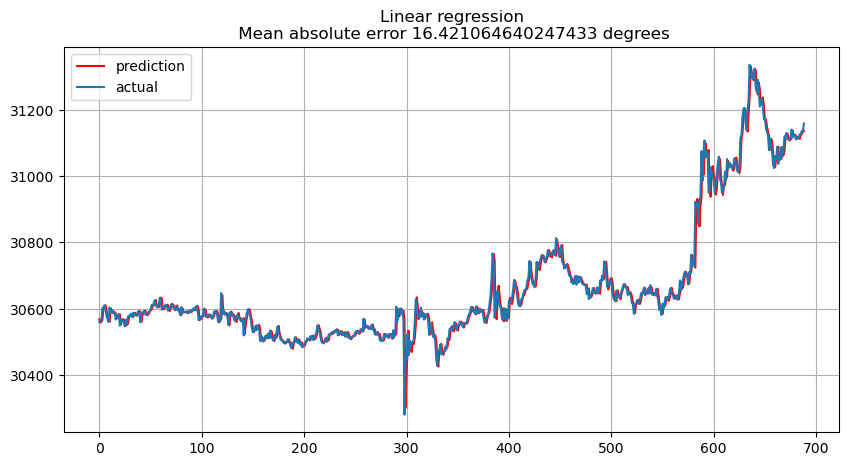

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

Попробуйте подобрать гиперпараметры `lag_start`, `lag_end`, а также придумать новые полезные агрегрированные признаки для улучшения качества прогноза.

Пропорции разбиения (в тесте 15% данных) не трогайте. Ошибку MAE все так же считайте на тесте.

In [62]:
# your code here

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

# первый вариант без доп фичей кроме лагов
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):
    data = data.sort_index() # проверка на дурака

    # your code here
    data["hour"] = pd.Series(data.index, index=data.index).dt.hour
    data["day"] = pd.Series(data.index, index=data.index).dt.day
    data["weekday"] = pd.Series(data.index, index=data.index).dt.weekday

    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['open'].shift(i)
    data[f"rolling_volume"] = data['volume'].rolling(20).mean().shift(1)
    data[f"rolling_open"] = data['open'].rolling(20).mean().shift(1)

    data = data.dropna()

    date_cut = data.iloc[int(data.shape[0] * (1 - 0.15))].name

    for col in ["hour", "day", "weekday"]:
        data[f"{col}_mean"] = list(map(code_mean(data[:date_cut], col, "open").get, data[col]))
        data[f"{col}_mean"] = data[col].fillna(0)
        data = data.drop(col, axis=1)


    X_train = data.loc[:date_cut].drop(["open"], axis=1)
    y_train = data.loc[:date_cut]["open"]
    X_test = data.loc[date_cut:].drop(["open"], axis=1)
    y_test = data.loc[date_cut:]["open"]

    return X_train, X_test, y_train, y_test

In [63]:
# your code here
data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
        parse_dates=True,
        index_col='timestamp'
        )
# data = data[['open']]
X_train, X_test, y_train, y_test = preprocess_data(data, 1)
X_train.shape, X_test.shape

((3900, 28), (689, 28))

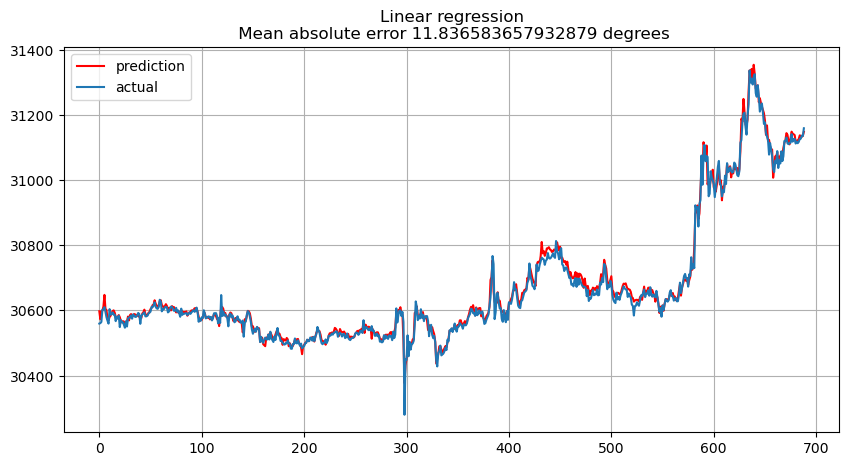

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees")
plt.show()

In [48]:
t = data.head(40)

In [49]:
t

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204
2023-06-18 00:25:00,26437.12,26497.0,26420.83,26473.00,45.7398
2023-06-18 00:30:00,26477.27,26499.0,26439.73,26442.51,18.2486
2023-06-18 00:35:00,26442.69,26491.0,26438.14,26450.00,24.9993
2023-06-18 00:40:00,26447.93,26481.0,26406.58,26406.97,52.4069
